# Analisis estadistico para Predicci√≥n de Deslizamientos mediante Machine Learning
---
**Modulo: Metodolog√≠as √Ågiles para el Desarrollo de Proyectos con Machine Learning**

- *Nixon Ivan Sotelo Figueroa*
- *Juan Andres Martinez Moreno*
- *David Mateo Granados Sarmiento*

*Geologos Universidad Nacional de Colombia*

## Reproyectar todos los Rasters utilizados

In [83]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import os
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [5]:
def reproject_and_resample_raster(
    input_raster_path,
    output_raster_path,
    target_crs="EPSG:32618",
    target_resolution=30,
    resampling_method=Resampling.bilinear
):
    """
    Reproyecta y reescala un archivo r√°ster a un CRS y resoluci√≥n deseada.

    Par√°metros:
    - input_raster_path: ruta al archivo de entrada (.tif)
    - output_raster_path: ruta de salida (.tif)
    - target_crs: sistema de coordenadas de destino (por defecto UTM zona 18N)
    - target_resolution: resoluci√≥n deseada en unidades del CRS (ej. 30 m)
    - resampling_method: m√©todo de remuestreo (bilinear por defecto)

    Devuelve:
    - ruta del archivo de salida
    """
    try:
        with rasterio.open(input_raster_path) as src:
            if src.crs is None:
                raise ValueError("El r√°ster de entrada no tiene un sistema de coordenadas definido.")

            # Calcular transformaci√≥n y dimensiones del r√°ster reproyectado
            transform, width, height = calculate_default_transform(
                src.crs, target_crs, src.width, src.height, *src.bounds, resolution=target_resolution
            )

            profile = src.profile.copy()
            profile.update({
                'crs': target_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(output_raster_path, 'w', **profile) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=target_crs,
                        resampling=resampling_method
                    )
        print(f"‚úÖ Reproyecci√≥n y remuestreo completados: {output_raster_path}")
        return output_raster_path

    except Exception as e:
        print(f"‚ùå Error al procesar el r√°ster: {e}")
        return None

In [215]:
#Usa Resampling.nearest si vas a reprocesar datos categ√≥ricos como geolog√≠a o uso del suelo.

#Usa Resampling.bilinear o cubic para datos continuos como NDVI, pendiente, precipitaci√≥n.

reproject_and_resample_raster(
    input_raster_path=r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\dem_srtm_30m.tif",
    output_raster_path=r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\dem2_srtm_30m.tif",
    target_crs="EPSG:32618",
    target_resolution=30,
    resampling_method=Resampling.bilinear  # o .nearest para datos categ√≥ricos
)

‚úÖ Reproyecci√≥n y remuestreo completados: C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\dem2_srtm_30m.tif


'C:\\Users\\Lenovo\\Documents\\Diplomado_ML\\Hackaton\\Reescalamiento\\dem2_srtm_30m.tif'

## Stack multibanda
---
| Banda | Rango observado (min‚Äìmax) | Variable original                                                                                                               |
| ----- | ------------------------- | -------------------------------|
| 1     | 0.0 ‚Äì 84.12               | **Pendiente**     |                                                                          
| 2     | -3.4e+38 ‚Äì 259.73 üõë      | **TRI** ‚ö†Ô∏è           |
| 3     | 0.0 ‚Äì 5800               | **DEM**                             | 
| 4     | 0.0 ‚Äì 0.162               | **Distancia a fallas**          |                                                                        
| 5     | -0.026 ‚Äì 0.868            | **NDVI**    |                                                                        
| 6     | 0.0 ‚Äì 233.87              | **Precipitaci√≥n** |                                                                         
| 7     | 1 ‚Äì 127                   | **Geolog√≠a** |                |
| 8     | 0 ‚Äì 3                     | **TWI clasificado**             |

In [62]:
def crear_stack_multibanda(directorio, salida_stack):
    """
    Detecta todos los archivos .tif en un directorio y genera un stack multibanda.
    
    Par√°metros:
    - directorio: ruta a la carpeta donde est√°n los .tif
    - salida_stack: nombre del archivo .tif multibanda a guardar

    Resultado:
    - Guarda un archivo .tif multibanda con todos los r√°sters alineados
    """
    # Detectar archivos .tif en el directorio
    raster_files = sorted([
        os.path.join(directorio, f)
        for f in os.listdir(directorio)
        if f.lower().endswith(".tif")
    ])

    if not raster_files:
        raise FileNotFoundError("No se encontraron archivos .tif en el directorio.")

    print(f"Se encontraron {len(raster_files)} archivos .tif. Apilando...")

    # Leer metadatos base del primer r√°ster
    with rasterio.open(raster_files[0]) as src_ref:
        meta = src_ref.meta.copy()
        height, width = src_ref.height, src_ref.width
        dtype = src_ref.dtypes[0]
        crs = src_ref.crs
        transform = src_ref.transform

    # Actualizar metadatos para el stack
    meta.update({
        "count": len(raster_files),
        "dtype": dtype,
        "height": height,
        "width": width,
        "crs": crs,
        "transform": transform
    })

    # Crear el archivo de salida multibanda
    with rasterio.open(salida_stack, "w", **meta) as dst:
        for i, path in enumerate(raster_files, start=1):
            with rasterio.open(path) as src:
                band = src.read(1)
                dst.write(band, i)

    print(f"‚úÖ Stack multibanda guardado como: {salida_stack}")
    return salida_stack

In [219]:
directorio_rasters = r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m"
salida = os.path.join(directorio_rasters, "stack_landslide_def.tif")

crear_stack_multibanda(directorio_rasters, salida)

Se encontraron 8 archivos .tif. Apilando...
‚úÖ Stack multibanda guardado como: C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m\stack_landslide_def.tif


'C:\\Users\\Lenovo\\Documents\\Diplomado_ML\\Hackaton\\Reescalamiento\\30m\\stack_landslide_def.tif'

### Visualizaci√≥n

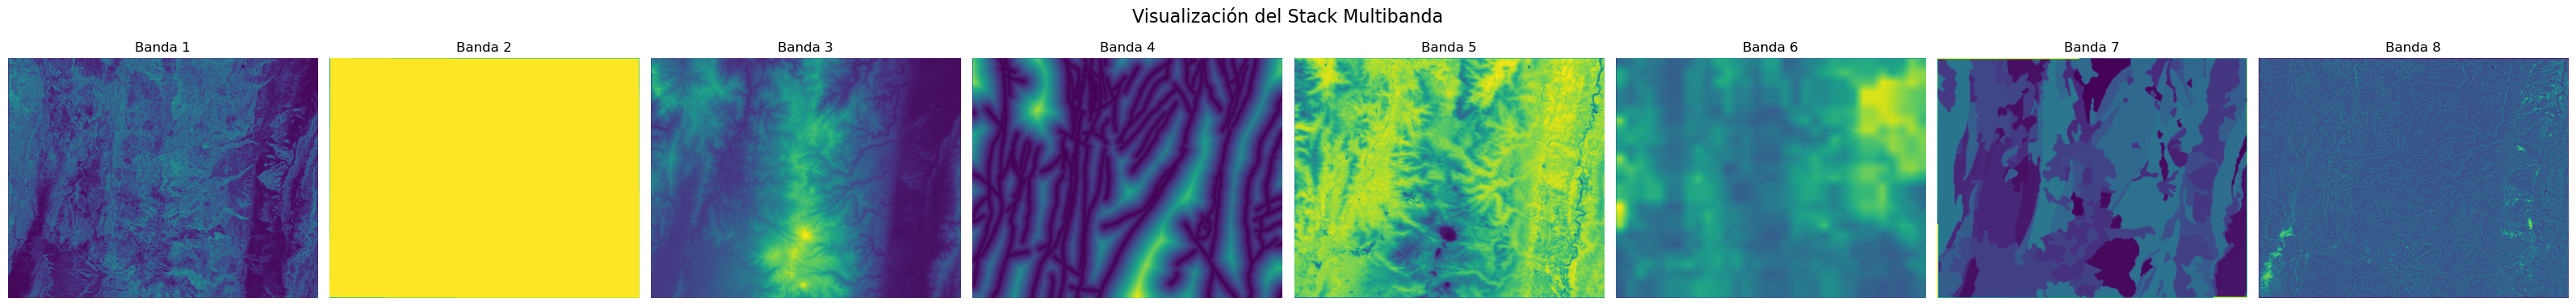

In [13]:
# Ruta al stack multibanda
ruta_stack = r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m\stack_landslide_def.tif"

# Abrir el archivo multibanda
with rasterio.open(ruta_stack) as src:
    num_bandas = src.count
    fig, axes = plt.subplots(1, num_bandas, figsize=(4*num_bandas, 4))

    for i in range(num_bandas):
        banda = src.read(i + 1)
        ax = axes[i] if num_bandas > 1 else axes
        ax.imshow(banda, cmap='viridis')
        ax.set_title(f'Banda {i+1}')
        ax.axis('off')

    plt.suptitle("Visualizaci√≥n del Stack Multibanda", fontsize=16)
    plt.tight_layout()
    plt.show()

Un **stack multibanda** es una imagen raster compuesta por varias bandas (capas) en las que cada una representa una variable geoespacial distinta. En este caso, el stack representa variables relevantes para modelar la susceptibilidad a deslizamientos.

1. Se recopilaron y reproyectaron a la misma resoluci√≥n (30m) una serie de r√°sters geoespaciales en formato .tif:

NDVI (vegetaci√≥n)

SLOPE (pendiente)

TRI (rugosidad del terreno)

TWI (√≠ndice topogr√°fico de humedad)

Precipitaci√≥n m√°xima hist√≥rica

Distancia a fallas

Mapa geol√≥gico clasificado

2. Se ubicaron en un mismo directorio y se utiliz√≥ una funci√≥n personalizada para:

Leer todos los .tif.

Validar alineaci√≥n espacial y tama√±o.

Apilar las bandas en un √∫nico archivo .tif multibanda llamado:
-  **stack_landslide_def.tif**

## Extraccion de imagenes
---

Imagenes de 13x13x7 (8 por el numero de bandas que componen las imagenes)

In [225]:
from rasterio.windows import Window
import pandas as pd

# --- Par√°metros ---
stack_path = "C:/Users/Lenovo/Documents/Diplomado_ML/Hackaton/Reescalamiento/30m/stack_landslide_def.tif"
puntos_csv = "C:/Users/Lenovo/Documents/Diplomado_ML/Hackaton/puntos_reproyectados_epsg32618.csv"
ventana = 13  # Tama√±o de ventana (13x13 p√≠xeles)
mitad = ventana // 2

# --- Leer puntos ---
df_puntos = pd.read_csv(puntos_csv)

# --- Inicializar listas para cubos y etiquetas ---
cubos = []
etiquetas = []

In [227]:
# --- Abrir stack multibanda ---
with rasterio.open(stack_path) as src:
    for _, row in df_puntos.iterrows():
        x, y, etiqueta = row["x"], row["y"], row["deslizamiento"]

        try:
            # Convertir coordenada a √≠ndice de p√≠xel
            col, row_idx = src.index(x, y)

            # Definir ventana alrededor del p√≠xel
            ventana_raster = Window(col - mitad, row_idx - mitad, ventana, ventana)

            # Verificar que la ventana est√© dentro de los l√≠mites
            if (col - mitad < 0 or row_idx - mitad < 0 or
                col + mitad >= src.width or row_idx + mitad >= src.height):
                continue  # saltar bordes

            # Leer el cubo multibanda
            cube = src.read(window=ventana_raster)  # (bands, rows, cols)
            cube = np.transpose(cube, (1, 2, 0))     # (rows, cols, bands)

            # Agregar a la lista
            cubos.append(cube)
            etiquetas.append(etiqueta)

        except Exception as e:
            print(f"Error con punto ({x}, {y}): {e}")
            continue

In [228]:
# --- Convertir a arrays ---
X = np.array(cubos, dtype=np.float32)
y = np.array(etiquetas, dtype=np.uint8)

# --- Guardar en archivos .npy ---
np.save("X_cubos2.npy", X)
np.save("y_etiquetas2.npy", y)

X.shape, y.shape

((851, 13, 13, 8), (851,))

In [231]:
# Rutas de guardado
ruta_guardado = r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m"  # ‚Üê cambia esto si es necesario
os.makedirs(ruta_guardado, exist_ok=True)

# Asignar nombres de archivo
ruta_X = os.path.join(ruta_guardado, "X_cubos2.npy")
ruta_y = os.path.join(ruta_guardado, "y_etiquetas2.npy")

# Guardar arrays
np.save(ruta_X, X)
np.save(ruta_y, y)

print("‚úÖ Datos guardados en:")
print(" -", ruta_X)
print(" -", ruta_y)

‚úÖ Datos guardados en:
 - C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m\X_cubos2.npy
 - C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m\y_etiquetas2.npy


## Explorar datos

### Valores maximos y minimos

In [245]:
#Valores maximos y minimos
ruta_stack = "C:/Users/Lenovo/Documents/Diplomado_ML/Hackaton/Reescalamiento/30m/stack_landslide_def.tif"

with rasterio.open(ruta_stack) as src:
    print(f"üóÇÔ∏è N√∫mero de bandas: {src.count}")
    for i in range(1, src.count + 1):
        band = src.read(i)
        print(f"Banda {i} - min: {band.min()}, max: {band.max()}, dtype: {band.dtype}")

üóÇÔ∏è N√∫mero de bandas: 8
Banda 1 - min: 0.0, max: 84.12029266357422, dtype: float32
Banda 2 - min: -3.4028230607370965e+38, max: 259.73077392578125, dtype: float32
Banda 3 - min: 0.0, max: 5287.0, dtype: float32
Banda 4 - min: 0.0, max: 0.16296102106571198, dtype: float32
Banda 5 - min: -0.026500258594751358, max: 0.8685486316680908, dtype: float32
Banda 6 - min: 0.0, max: 233.87876892089844, dtype: float32
Banda 7 - min: 1.0, max: 127.0, dtype: float32
Banda 8 - min: 0.0, max: 3.0, dtype: float32


### Datos faltantes y datos duplicados

In [39]:
ruta = r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m"
X = np.load(ruta + r"\X_cubos2.npy")   # Shape: (851, 13, 13, 8)
y = np.load(ruta + r"\y_etiquetas2.npy")  # Shape: (851,)

In [47]:
# --- Convertir X a 2D para an√°lisis m√°s sencillo ---
X_flat = X.reshape((X.shape[0], -1))  # (851, 1352)
df = pd.DataFrame(X_flat)
df['label'] = y  # Agregamos etiqueta

# --- An√°lisis de calidad ---

# 1. Valores faltantes
faltantes = df.isnull().sum()
faltantes_pct = (faltantes / len(df)) * 100

# 2. Duplicados exactos
duplicados = df.duplicated().sum()

In [55]:
#Reduccion a una matriz de forma (851,1353) para analisis estadistico
df

0         1       2         3         4           5     6    7  \
0    30.644804  2.130437  1269.0  0.061688  0.711602  101.529327  28.0  1.0   
1     6.266970  1.470367  2056.0  0.083005  0.689107   76.252487  28.0  3.0   
2    10.198944  3.106801  1837.0  0.005226  0.522140  108.791046  43.0  1.0   
3    24.413549  4.600995  1315.0  0.019213  0.719797  108.417236  43.0  1.0   
4     2.376682  0.649197   994.0  0.001526  0.742165  121.075607   9.0  1.0   
..         ...       ...     ...       ...       ...         ...   ...  ...   
846  33.074814  4.919672  2495.0  0.038577  0.483785   88.718590  44.0  2.0   
847  23.665665  4.361445  1380.0  0.008314  0.657019  108.681953  25.0  1.0   
848   9.095751  2.795441  2228.0  0.091253  0.524596  124.797096  48.0  0.0   
849  27.409842  0.785694  1385.0  0.010747  0.718946  116.238365  44.0  1.0   
850  22.417135  8.440955  2734.0  0.070548  0.422348   92.240517  22.0  0.0   

             8         9  ...  1343       1344      1345    1346      1347  \
0    28.634285  1.426778  ...   0.0  20.207291  2.866571  1160.0  0.060870   
1    12.091671  1.859099  ...   0.0  13.656597  2.297070  2129.0  0.082554   
2    12.908612  2.055550  ...   1.0  35.456390  4.620565  1760.0  0.001793   
3    16.103748  3.439181  ...   1.0  34.196270  3.080103  1412.0  0.019897   
4     2.277080  0.243703  ...   0.0  16.423416  0.686378  1091.0  0.000909   
..         ...       ...  ...   ...        ...       ...     ...       ...   
846  30.486755  2.336245  ...   1.0  46.953201  2.069592  2276.0  0.042732   
847  24.790514  3.316334  ...   1.0   3.378961  1.134384  1442.0  0.004293   
848   4.276231  3.771112  ...   1.0  40.268990  0.798605  2148.0  0.095823   
849  26.955894  2.680974  ...   0.0  29.427980  4.077579  1359.0  0.006764   
850  26.865788  2.338232  ...   0.0  22.979557  5.489929  2542.0  0.067580   

         1348        1349  1350  1351  label  
0    0.754885  100.243225  25.0   0.0      1  
1    0.650471   76.676575  28.0   0.0      1  
2    0.477892  107.619652  24.0   1.0      1  
3    0.710600  107.583725  43.0   1.0      1  
4    0.762212  120.253235   9.0   0.0      1  
..        ...         ...   ...   ...    ...  
846  0.571923   91.703979  44.0   1.0      0  
847  0.630119  109.463852  25.0   1.0      0  
848  0.535725  123.143677  48.0   1.0      0  
849  0.697966  121.402245  44.0   0.0      0  
850  0.492467   92.894279  22.0   0.0      0  

[851 rows x 1353 columns]

In [51]:
# --- Mostrar resumen ---
print("üîé Diagn√≥stico de Calidad de Datos\n")
print("üìå Valores faltantes por columna (con %):")
print(pd.DataFrame({'Faltantes': faltantes, '%': faltantes_pct}) \
        .query('Faltantes > 0') \
        .sort_values(by='%', ascending=False))


üîé Diagn√≥stico de Calidad de Datos

üìå Valores faltantes por columna (con %):
Empty DataFrame
Columns: [Faltantes, %]
Index: []


In [61]:
# Convertir a DataFrame para facilitar an√°lisis
df_y = pd.DataFrame(y, columns=["Deslizamiento"])

# Calcular distribuci√≥n de clases
class_counts = df_y["Deslizamiento"].value_counts().sort_index()
class_percent = df_y["Deslizamiento"].value_counts(normalize=True).sort_index() * 100

# Crear una figura con dos subgr√°ficos
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Gr√°fico de barras - Conteo
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axs[0], palette="Set2")
axs[0].set_title("Distribuci√≥n de la variable objetivo")
axs[0].set_xlabel("Clase")
axs[0].set_ylabel("Frecuencia")
axs[0].set_xticklabels(["No Deslizamiento", "Deslizamiento"])

# Gr√°fico de pastel - Porcentaje
axs[1].pie(class_percent, labels=["No Deslizamiento", "Deslizamiento"], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
axs[1].set_title("Porcentaje por clase")

plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25772\828824849.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, ax=axs[0], palette="Set2")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25772\828824849.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["No Deslizamiento", "Deslizamiento"])


In [139]:

# --- 2. Estad√≠sticas por banda ---
def plot_band_statistics_sampled(X, sample_frac=0.05, bins=100):
    num_bands = X.shape[-1]
    fig, axes = plt.subplots(1, num_bands, figsize=(22, 3))

    total_pixels = X.shape[0] * X.shape[1] * X.shape[2]
    sample_size = int(total_pixels * sample_frac)

    for i in range(num_bands):
        data = X[:, :, :, i].flatten()
        sample = np.random.choice(data, size=sample_size, replace=False)
        axes[i].hist(sample, bins=bins, color='cornflowerblue')
        axes[i].set_title(f'Banda {i+1}')
        axes[i].set_xlabel("Valor")
    plt.tight_layout()
    plt.show()

# --- 3. Ejemplos aleatorios por clase ---
def plot_sample_cubes(X, y, num_samples=3):
    classes = [0, 1]
    for label in classes:
        idx = np.where(y == label)[0]
        selected = np.random.choice(idx, num_samples, replace=False)
        fig, axes = plt.subplots(1, num_samples, figsize=(10, 3))
        fig.suptitle(f"Ejemplos de la clase {label}")
        for i, ax in enumerate(axes):
            img = X[selected[i], :, :, :3]  # Mostrar RGB
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalizar para visualizaci√≥n
            ax.imshow(img)
            ax.axis('off')
        plt.show()


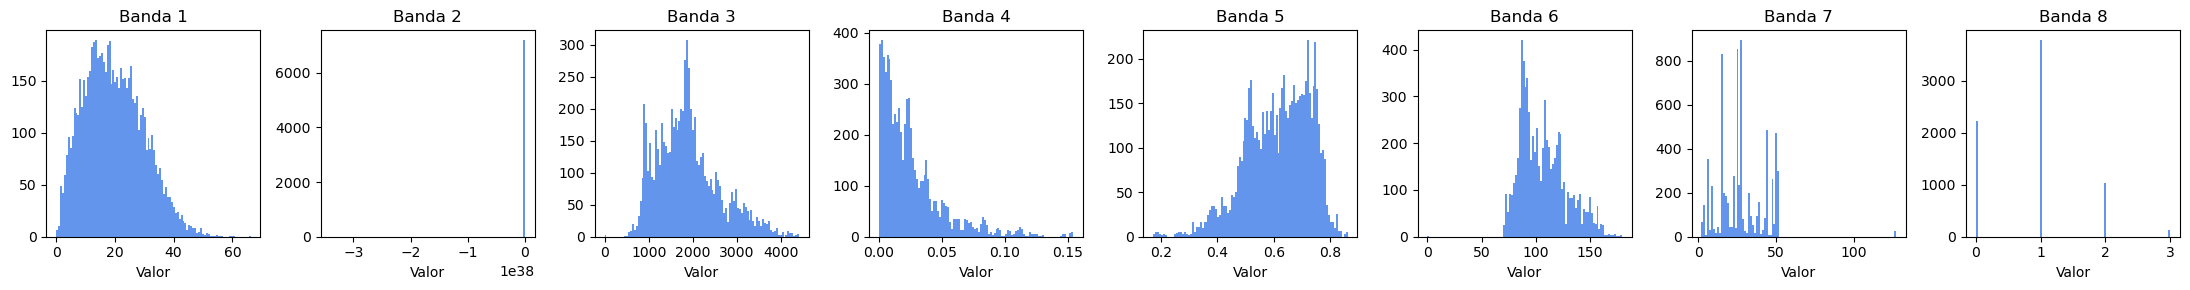

In [237]:
plot_band_statistics_sampled(X, sample_frac=0.05)

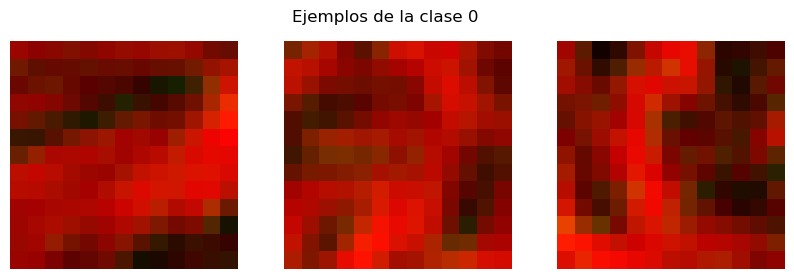

In [188]:
plot_sample_cubes(X, y)

‚úÖ Observaciones clave:
Distribuci√≥n de clases balanceada:

Hay aproximadamente la misma cantidad de muestras etiquetadas como deslizamiento (1) y no deslizamiento (0).

‚úÖ Esto es bueno porque evita un sesgo del modelo hacia una clase dominante.

Problema en la Banda 2:

Su histograma muestra un pico extremadamente elevado en valores an√≥malos, probablemente debido a valores nulos, NaN, infinitos o un error de escala (valores cercanos a ¬±1e36).

‚ö†Ô∏è Esto puede causar que el modelo no aprenda correctamente, ya que los valores an√≥malos dominan el rango din√°mico.

Variabilidad de escalas:

Algunas bandas tienen valores muy peque√±os (por ejemplo, banda 3 y banda 4) mientras que otras (como la 5 o la 6) tienen valores entre 0 y 1, y otras son discretas (como la banda 7 con valores muy puntuales).

Esto sugiere que normalizar o estandarizar por banda ser√≠a una estrategia necesaria para mejorar el rendimiento.


Forma de X: (851, 13, 13, 8)
Forma de y: (851,)


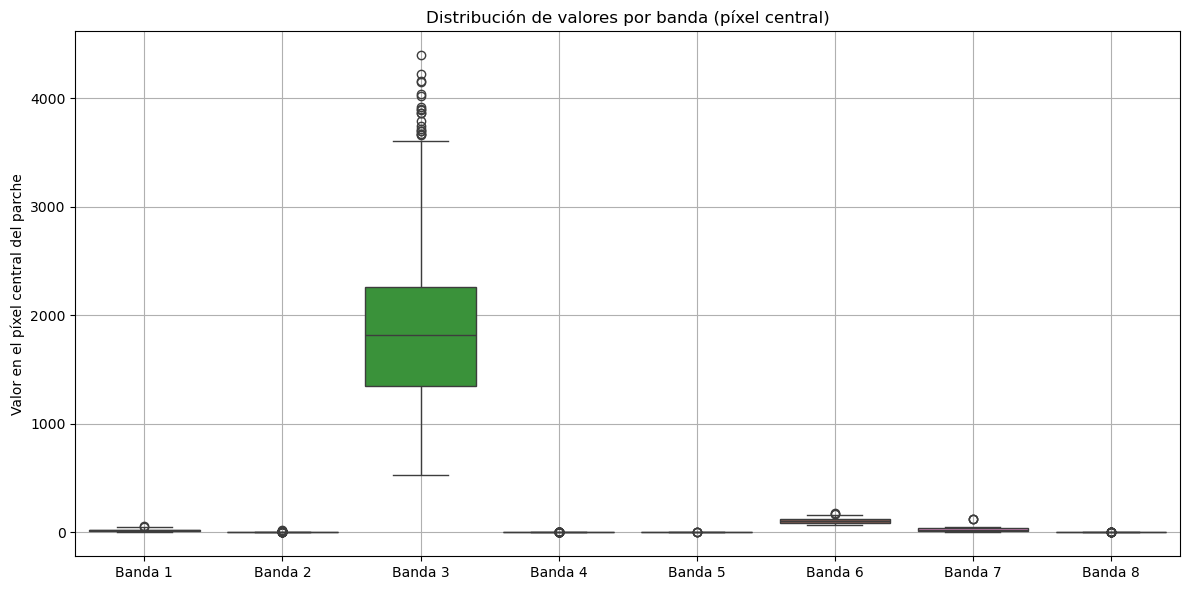

In [239]:
# Cargar los datos
X = np.load("X_cubos2.npy")
y = np.load("y_etiquetas2.npy")

# Verificar dimensiones
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# Crear boxplots por banda en el centro del parche
num_bandas = X.shape[-1]
valores_centro = []

for i in range(num_bandas):
    valores_banda = X[:, X.shape[1]//2, X.shape[2]//2, i]
    valores_centro.append(valores_banda)

# Plotear boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=valores_centro)
plt.xticks(ticks=range(num_bandas), labels=[f"Banda {i+1}" for i in range(num_bandas)])
plt.ylabel("Valor en el p√≠xel central del parche")
plt.title("Distribuci√≥n de valores por banda (p√≠xel central)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Variables mas importantes

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Aplanar los datos para an√°lisis
X_flat = X.reshape(X.shape[0], -1)

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# 1. Ranking por modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)
importances = rf.feature_importances_

# Top 15 variables m√°s importantes seg√∫n Random Forest
indices_rf = np.argsort(importances)[::-1][:15]
ranking_rf = pd.DataFrame({
    "Variable": indices_rf,
    "Importancia_RF": importances[indices_rf]
})

In [70]:
# 2. PCA para varianza explicada por componente
pca = PCA(n_components=15)
pca.fit(X_scaled)
explained_var = pca.explained_variance_ratio_

ranking_pca = pd.DataFrame({
    "Componente": np.arange(1, 16),
    "Varianza_Explicada": explained_var
})

In [72]:
# 3. Correlaci√≥n con la variable objetivo
df_flat = pd.DataFrame(X_scaled)
df_flat["target"] = y
correlations = df_flat.corr()["target"].drop("target")
correlation_abs = correlations.abs().sort_values(ascending=False)[:15]

In [78]:
# Crear ranking de correlaci√≥n (aseg√∫rate de ejecutar esto primero)
ranking_corr = pd.DataFrame({
    "Variable": correlation_abs.index,
    "Correlacion_Abs": correlation_abs.values
})

In [80]:
# Crear visualizaci√≥n con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(data=ranking_rf, x="Importancia_RF", y="Variable", ax=axes[0], palette="Blues_d")
axes[0].set_title("Importancia (Random Forest)")
axes[0].set_xlabel("Importancia")
axes[0].set_ylabel("Variable")

sns.barplot(data=ranking_pca, x="Varianza_Explicada", y="Componente", ax=axes[1], palette="Greens_d")
axes[1].set_title("PCA - Varianza Explicada")
axes[1].set_xlabel("Varianza")
axes[1].set_ylabel("Componente Principal")

sns.barplot(data=ranking_corr, x="Correlacion_Abs", y="Variable", ax=axes[2], palette="Reds_d")
axes[2].set_title("Correlaci√≥n con Variable Objetivo")
axes[2].set_xlabel("Correlaci√≥n Absoluta")
axes[2].set_ylabel("Variable")

plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25772\3103695697.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ranking_rf, x="Importancia_RF", y="Variable", ax=axes[0], palette="Blues_d")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25772\3103695697.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ranking_pca, x="Varianza_Explicada", y="Componente", ax=axes[1], palette="Greens_d")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25772\3103695697.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ranking_corr, x="Correlacio

Conclusi√≥n:
| Banda | Variable original               | Grado de importancia                |
| ----- | ------------------------------- | ----------------------------------- |
| 0     | Pendiente                       | ‚≠ê‚≠ê‚≠ê‚≠ê Muy Alta                       |
| 1     | TRI (algunos valores corruptos) | ‚≠ê‚≠ê Media (con reservas por errores) |
| 2     | DEM                             | ‚≠ê‚≠ê‚≠ê‚≠ê Muy Alta                       |
| 3     | Distancia a fallas              | ‚≠ê Baja                              |
| 4     | NDVI                            | ‚≠ê‚≠ê‚≠ê Alta                            |
| 5     | Precipitaci√≥n                   | ‚≠ê‚≠ê‚≠ê Alta                            |
| 6     | Geolog√≠a (categor√≠a)            | ‚≠ê‚≠ê Media                            |
| 7     | TWI Clasificado                 | ‚≠ê‚≠ê Media-Baja                       |


## Normalilzar datos

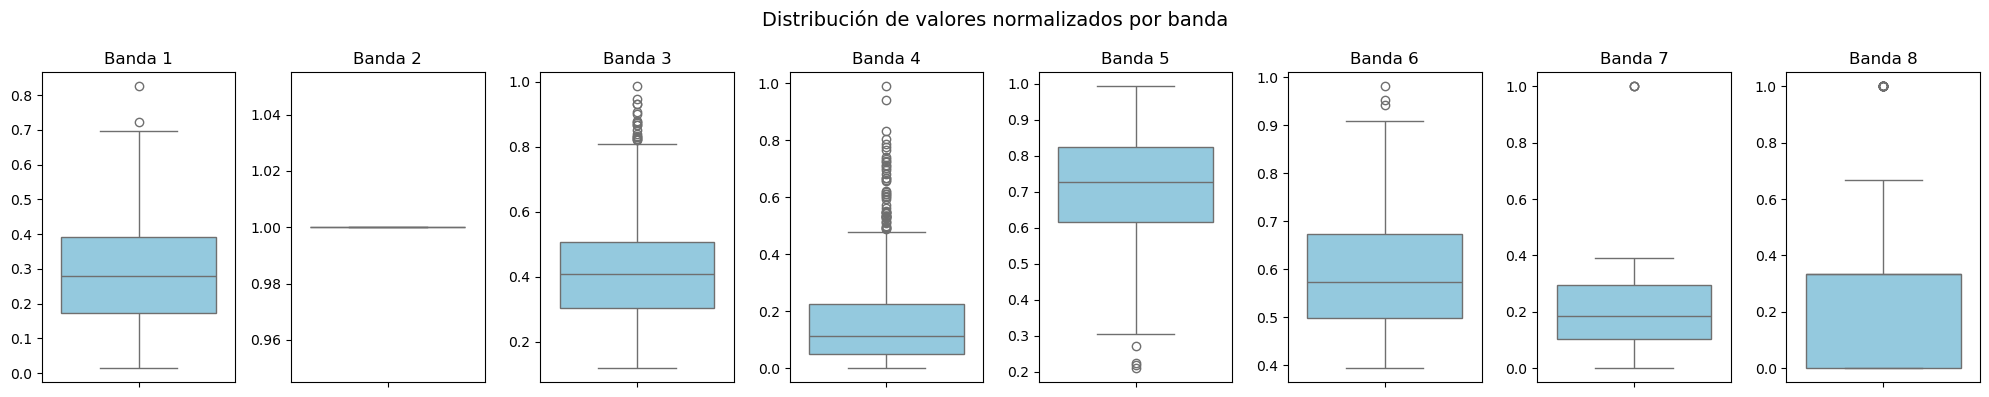

In [247]:
# Normalizaci√≥n min-max por banda
x_norm = np.empty_like(X, dtype=np.float32)
for b in range(X.shape[-1]):
    band = X[:, :, :, b]
    min_val = band.min()
    max_val = band.max()
    x_norm[:, :, :, b] = (band - min_val) / (max_val - min_val + 1e-8)

# An√°lisis gr√°fico por banda normalizada
fig, axes = plt.subplots(1, X.shape[-1], figsize=(20, 4))
fig.suptitle("Distribuci√≥n de valores normalizados por banda", fontsize=14)

for b in range(X.shape[-1]):
    centro_patch = x_norm[:, X.shape[1]//2, X.shape[2]//2, b]
    sns.boxplot(y=centro_patch, ax=axes[b], color='skyblue')
    axes[b].set_title(f'Banda {b+1}')
    axes[b].set_ylabel('')

plt.tight_layout()
plt.show()

Conclusiones por banda:

- Banda 1: Distribuci√≥n adecuada con variabilidad. ‚úîÔ∏è √ötil.

- Banda 2: Todos los valores est√°n en 1.0 (distribuci√≥n constante). ‚ö†Ô∏è No aporta informaci√≥n √∫til ‚Üí deber√≠as descartarla.

- Banda 3: Distribuci√≥n sesgada pero con variabilidad. ‚úîÔ∏è √ötil.

- Banda 4: Distribuci√≥n amplia y diferenciada. ‚úîÔ∏è √ötil.

- Banda 5: Distribuci√≥n normalizada razonable. ‚úîÔ∏è √ötil.

- Banda 6: Algunos valores muy extremos, pero conserva dispersi√≥n. ‚úîÔ∏è √ötil (con precauci√≥n).

- Banda 7: Buena variabilidad, √∫til. ‚úîÔ∏è

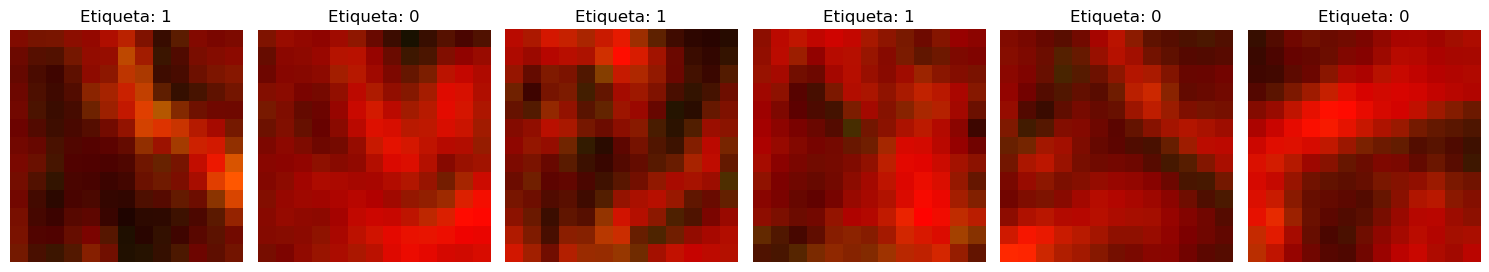

In [128]:
# Visualizar algunos cubos aleatorios
def visualizar_cubos(X, y, num=6):
    indices = np.random.choice(len(X), size=num, replace=False)
    fig, axes = plt.subplots(1, num, figsize=(15, 3))

    for i, idx in enumerate(indices):
        cube = X[idx]
        label = y[idx]

        # Seleccionamos 3 bandas para mostrar como RGB (ejemplo: bandas 0, 1, 2)
        rgb = cube[:, :, :3]
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalizar para visualizar

        axes[i].imshow(rgb)
        axes[i].axis("off")
        axes[i].set_title(f"Etiqueta: {label}")

    plt.tight_layout()
    plt.show()

visualizar_cubos(X, y, num=6)

## Relaci√≥n entre variables explicativas y variable objetivo

In [96]:
# Cargar imagen multibanda
ruta_stack = r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m\stack_landslide_def.tif"
with rasterio.open(ruta_stack) as src:
    bands = [src.read(i + 1).flatten() for i in range(src.count)]
    mask = np.all([~np.isnan(b) for b in bands], axis=0)  # M√°scara sin NaNs
    data = np.stack(bands, axis=1)[mask]  # (n_pixels, n_bandas)

# Crear DataFrame
nombres_bandas = ['Pendiente', 'TRI', 'DEM', 'Dist. a fallas',
                  'NDVI', 'Precipitaci√≥n', 'Geolog√≠a', 'TWI']
df_bandas = pd.DataFrame(data, columns=nombres_bandas)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25772\3854116902.py:5: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


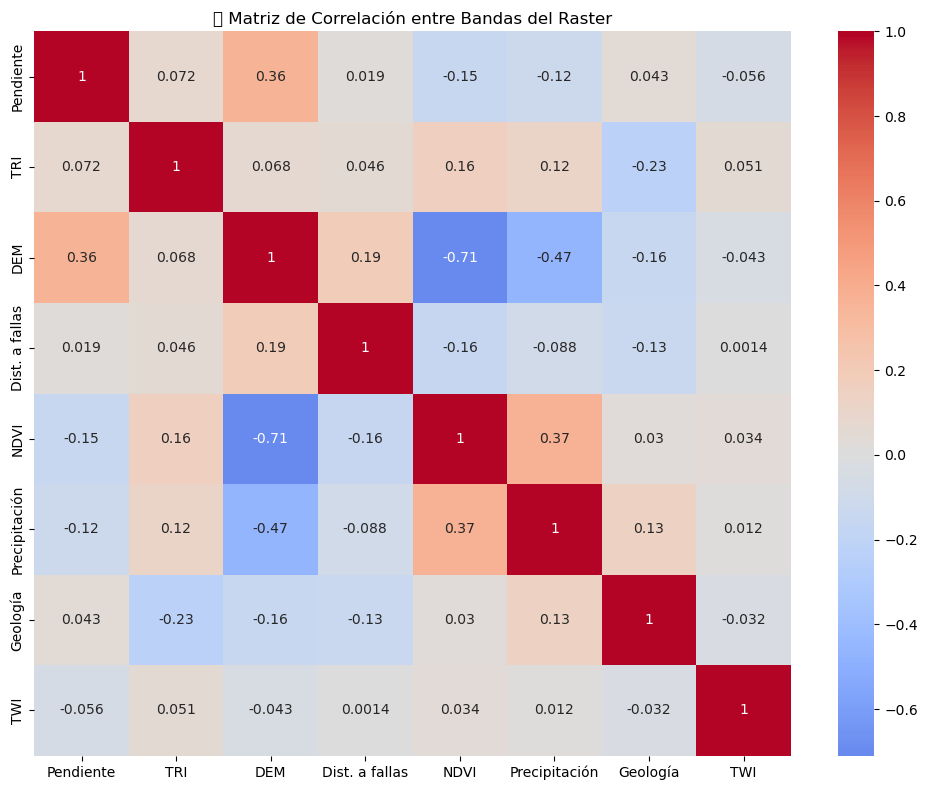

In [98]:
# Matriz de correlaci√≥n
plt.figure(figsize=(10, 8))
sns.heatmap(df_bandas.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("üìä Matriz de Correlaci√≥n entre Bandas del Raster")
plt.tight_layout()
plt.show()

*Conclusi√≥n:*

| Relaci√≥n                     | Interpretaci√≥n                                                            |
| ---------------------------- | ------------------------------------------------------------------------- |
| `DEM vs NDVI`                | Fuerte inversa: menos vegetaci√≥n en zonas altas                           |
| `Precipitaci√≥n vs NDVI`      | Vegetaci√≥n algo mayor donde m√°s precipita                                 |
| `Pendiente vs DEM`           | L√≥gica: mayor pendiente en zonas elevadas                                 |
| `TWI / TRI / Dist. a fallas` | Variables con independencia estad√≠stica: pueden aportar informaci√≥n √∫nica |


## Subir a github

In [ ]:
!git clone https://github.com/DMGrana2/mlds_6.git >nul 2>&1

In [117]:
!move Analisis_exploratorio.ipynb mlds_6\scripts\eda\

El sistema no puede encontrar el archivo especificado.


In [ ]:
os.chdir("mlds_6")

In [123]:
print("Directorio actual:", os.getcwd())
print("Contenido de scripts/eda:", os.listdir("scripts/eda"))

Directorio actual: C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\mlds_6
Contenido de scripts/eda: ['Analisis_exploratorio.ipynb', 'main.py']


In [109]:
!git config --global user.email "nsotelof@unal.edu.co"
!git config --global user.name "Ivan Sotelo"

In [113]:
!git add scripts/eda/Analisis_exploratorio.ipynb
!git commit -m "Agregar notebook de an√°lisis exploratorio para Fase 2 V2"

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [37]:
!git push origin master

To https://github.com/DMGrana2/mlds_6.git
   f9db015..d42d862  master -> master
